In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet
from torchvision.models import mobilenet_v2
from torchvision.models import resnet18

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile


from sklearn.metrics import confusion_matrix
import seaborn as sns


import os
from pathlib import Path

import os
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/My Drive/Faulty_tyre_detection.zip'


extracted_folder_path = '/content/faulty_tyre_detection_dataset'

# Create directory if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

# Extract the zip file
import zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [ ]:
data_dir = '/content/faulty_tyre_detection_dataset/Digital images of defective and good condition tyres'
train_dir = os.path.join('/content/faulty_tyre_detection_dataset', 'train')
test_dir = os.path.join('/content/faulty_tyre_detection_dataset', 'test')

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define categories
categories = ['good', 'defective']

# Create category directories in train and test folders
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

def split_and_move_images(category):
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)

    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_images:
        shutil.move(os.path.join(category_path, img), os.path.join(train_dir, category, img))

    for img in test_images:
        shutil.move(os.path.join(category_path, img), os.path.join(test_dir, category, img))

In [ ]:
for category in categories:
    split_and_move_images(category)

In [ ]:
import os
def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(extracted_folder_path)

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get the image path list
image_path_list = []
for root, dirs, files in os.walk(extracted_folder_path):
    for file in files:
        if file.endswith(".jpg"):
            image_path_list.append(os.path.join(root, file))


# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = os.path.basename(os.path.dirname(random_image_path))

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
train_dir, test_dir

In [ ]:
transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly crop the image to 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.RandomRotation(15), # Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Randomly change the brightness, contrast, saturation, and hue
    transforms.RandomVerticalFlip(p=0.1), # Randomly flip the image vertically with a probability of 0.1
    transforms.ToTensor(), # Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [ ]:
train_data = datasets.ImageFolder(root=train_dir, transform=transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=transforms)

In [ ]:
num_workers = os.cpu_count()
batch_size = 32
time_out = 60
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=num_workers,
                              persistent_workers=True,
                              timeout = time_out,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False) # don't usually need to shuffle testing data

In [ ]:
def train_model(model, train_dataloader, criterion, optimizer, device, num_epochs=100, epochs_per_iteration=10):
    model.train()
    total_loss = 0.0
    total_correct_predictions = 0
    total_predictions = 0

    for iteration in range(num_epochs // epochs_per_iteration):
        print(f"Iteration {iteration + 1}/{num_epochs // epochs_per_iteration}:")
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for epoch in range(epochs_per_iteration):
            for batch_idx, (data, target) in enumerate(train_dataloader):
                data, target = data.to(device), target.to(device)  # Transfer data to device

                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()

                # Accumulate loss and calculate accuracy
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_predictions += target.size(0)
                correct_predictions += (predicted == target).sum().item()

            # Print epoch statistics
            epoch_loss = running_loss / len(train_dataloader)
            epoch_accuracy = correct_predictions / total_predictions * 100
            print(f"Epoch [{(iteration * epochs_per_iteration) + epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Accumulate statistics for the iteration
        total_loss += running_loss
        total_correct_predictions += correct_predictions

    # Calculate overall statistics
    overall_loss = total_loss / (len(train_dataloader) * (num_epochs // epochs_per_iteration))
    overall_accuracy = total_correct_predictions / (total_predictions * (num_epochs // epochs_per_iteration)) * 100

    print(f'Finished Training\nOverall Loss: {overall_loss:.4f}, Overall Accuracy: {overall_accuracy:.2f}%')


In [ ]:
def evaluation(model, test_dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    test_preds = []  # List to store predictions
    test_labels = []  # List to store true labels

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            # Append predictions and true labels to the lists
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_dataloader)
    accuracy = 100. * correct / len(test_dataloader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return test_loss, accuracy, test_labels, test_preds




In [ ]:
# Load pre-trained ResNet18
resnet18 = models.resnet18(pretrained=True)

# Replace the last layer (classifier) to match number of classes for fine-tuning
num_classes = len(train_data.classes)  # Assuming train_data contains your dataset
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Freeze all layers except the last layer for fine-tuning
for param in resnet18.parameters():
    param.requires_grad = False

for param in resnet18.fc.parameters():
    param.requires_grad = True


resnet18.to(device)

In [ ]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

In [ ]:
import time
t0 = time.time()
train_model(resnet18, train_dataloader, criterion, optimizer, device)
t_final = time.time()
print(f" Time taken {t_final - t0}")
save_model(resnet18, '/content/drive/MyDrive/faulty_tyre_resent18_checkpoint.pth')

In [ ]:
resnet18_test_loss, resnet18_test_accuracy, test_preds, test_labels = evaluation(resnet18, test_dataloader, criterion, device)

Test Loss: 0.2038, Test Accuracy: 91.94%


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

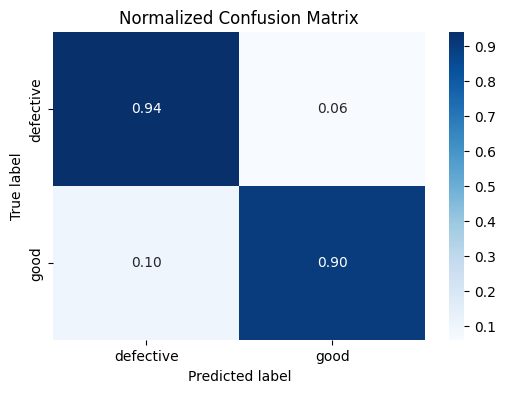

In [ ]:
class_names = train_data.classes
plot_confusion_matrix(test_labels, test_preds, class_names)